## Modelo de Identificación de Alta Conductividad en Canal de Drenaje de Molinos sin Día de Zafra

In [1]:
# Importacion de Librerias
import os
os.environ["OMP_NUM_THREADS"] = '5'

import numpy as np
import pandas as pd
import seaborn as sns
import funciones
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix,  f1_score, precision_score, recall_score, silhouette_score

#### Carga del Dataset (Variables del Sistema de Control)

Se utilizan los datos del medidor de conductividad en el canal del efluente indicado, tomando el valor promedio por hora.  

In [2]:
# Carga del Dataset
df_raw = pd.read_csv('Conductividad_Canal_Molinos.csv',sep=";" , encoding='latin1')  # Lectura del archivo csv
df_raw

,Inicio,Fin,FT553705 Flujo agua asepsia Patio T-A (Gpm) AVG,FT553705 Flujo agua asepsia Patio T-A (Gpm) STD,FT553707 Flujo agua asepsia Molinos T-A (Gpm) AVG,FT553707 Flujo agua asepsia Molinos T-A (Gpm) STD,FT553706 Flujo agua asepsia Molinos T-B (Gpm) AVG,FT553706 Flujo agua asepsia Molinos T-B (Gpm) STD,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) AVG,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) STD,...,LT580704 Nivel Vaso E1 (%) AVG,LT580704 Nivel Vaso E1 (%) STD,LT580604 Nivel Vaso E2 (%) AVG,LT580604 Nivel Vaso E2 (%) STD,LT581704 Nivel Vaso E3 (%) AVG,LT581704 Nivel Vaso E3 (%) STD,LT581603 Nivel Vaso E4 (%) AVG,LT581603 Nivel Vaso E4 (%) STD,CT55101 Conductividad Canal Molinos (uS) AVG,CT55101 Conductividad Canal Molinos (uS) STD
0,12/11/2023 00:00,12/11/2023 01:00,0.0,0.0,0.09,0.17,10.91,35.85,0.03,0.10,...,17.60,0.69,0.00,0.00,37.76,9.92,35.77,17.73,0.00,0.00
1,12/11/2023 01:00,12/11/2023 02:00,0.0,0.0,0.08,0.17,12.77,39.31,0.02,0.09,...,18.27,0.48,0.00,0.00,34.53,2.03,26.66,8.54,0.00,0.00
2,12/11/2023 02:00,12/11/2023 03:00,0.0,0.0,0.09,0.17,11.88,35.96,0.02,0.09,...,18.51,29.27,0.00,0.00,34.34,6.12,27.29,14.84,0.00,0.00
3,12/11/2023 03:00,12/11/2023 04:00,0.0,0.0,0.08,0.17,21.57,37.34,0.02,0.09,...,0.75,0.77,0.00,0.00,34.49,2.96,28.23,9.01,0.00,0.00
4,12/11/2023 04:00,12/11/2023 05:00,0.0,0.0,0.10,0.18,14.30,35.44,0.02,0.08,...,0.00,0.00,0.00,0.00,19.54,15.42,18.32,18.61,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2563,26/02/2024 19:00,26/02/2024 20:00,0.0,0.0,21.80,47.02,6.24,18.34,0.00,0.01,...,47.12,36.63,30.68,20.56,46.83,15.83,28.06,29.84,437.33,230.17
2564,26/02/2024 20:00,26/02/2024 21:00,0.0,0.0,24.92,51.72,8.10,21.69,0.00,0.01,...,31.73,10.44,39.68,1.99,38.86,5.63,38.56,5.49,311.98,130.99
2565,26/02/2024 21:00,26/02/2024 22:00,0.0,0.0,20.92,48.37,8.38,22.04,0.00,0.00,...,51.83,33.06,50.01,17.07,49.31,17.39,41.07,11.58,488.37,363.74
2566,26/02/2024 22:00,26/02/2024 23:00,0.0,0.0,27.44,48.98,8.21,20.23,0.00,0.01,...,77.64,16.26,41.10,4.36,48.37,12.99,39.73,5.00,53.37,21.13


#### Revision del conjunto de datos

In [3]:
# Se agrega el día de Zafra 
df_raw['Inicio'] = pd.to_datetime(df_raw['Inicio']) # Se convierte la columna inicio a tipo datetime
df_raw['Fin'] = pd.to_datetime(df_raw['Fin']) # Se convierte la columna inicio a tipo datetime
df_raw['Dia Zafra'] = pd.factorize(df_raw['Inicio'].dt.date)[0] + 1 # Se agrega la columna Dia Zafra a partir de la columna inicio
df_raw = pd.concat([df_raw['Dia Zafra'], df_raw.drop('Dia Zafra', axis=1)], axis=1) # Se pasa al inicio del conjunto de datos la columna dia de zafra
df_raw

,Dia Zafra,Inicio,Fin,FT553705 Flujo agua asepsia Patio T-A (Gpm) AVG,FT553705 Flujo agua asepsia Patio T-A (Gpm) STD,FT553707 Flujo agua asepsia Molinos T-A (Gpm) AVG,FT553707 Flujo agua asepsia Molinos T-A (Gpm) STD,FT553706 Flujo agua asepsia Molinos T-B (Gpm) AVG,FT553706 Flujo agua asepsia Molinos T-B (Gpm) STD,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) AVG,...,LT580704 Nivel Vaso E1 (%) AVG,LT580704 Nivel Vaso E1 (%) STD,LT580604 Nivel Vaso E2 (%) AVG,LT580604 Nivel Vaso E2 (%) STD,LT581704 Nivel Vaso E3 (%) AVG,LT581704 Nivel Vaso E3 (%) STD,LT581603 Nivel Vaso E4 (%) AVG,LT581603 Nivel Vaso E4 (%) STD,CT55101 Conductividad Canal Molinos (uS) AVG,CT55101 Conductividad Canal Molinos (uS) STD
0,1,2023-12-11 00:00:00,2023-12-11 01:00:00,0.0,0.0,0.09,0.17,10.91,35.85,0.03,...,17.60,0.69,0.00,0.00,37.76,9.92,35.77,17.73,0.00,0.00
1,1,2023-12-11 01:00:00,2023-12-11 02:00:00,0.0,0.0,0.08,0.17,12.77,39.31,0.02,...,18.27,0.48,0.00,0.00,34.53,2.03,26.66,8.54,0.00,0.00
2,1,2023-12-11 02:00:00,2023-12-11 03:00:00,0.0,0.0,0.09,0.17,11.88,35.96,0.02,...,18.51,29.27,0.00,0.00,34.34,6.12,27.29,14.84,0.00,0.00
3,1,2023-12-11 03:00:00,2023-12-11 04:00:00,0.0,0.0,0.08,0.17,21.57,37.34,0.02,...,0.75,0.77,0.00,0.00,34.49,2.96,28.23,9.01,0.00,0.00
4,1,2023-12-11 04:00:00,2023-12-11 05:00:00,0.0,0.0,0.10,0.18,14.30,35.44,0.02,...,0.00,0.00,0.00,0.00,19.54,15.42,18.32,18.61,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2563,107,2024-02-26 19:00:00,2024-02-26 20:00:00,0.0,0.0,21.80,47.02,6.24,18.34,0.00,...,47.12,36.63,30.68,20.56,46.83,15.83,28.06,29.84,437.33,230.17
2564,107,2024-02-26 20:00:00,2024-02-26 21:00:00,0.0,0.0,24.92,51.72,8.10,21.69,0.00,...,31.73,10.44,39.68,1.99,38.86,5.63,38.56,5.49,311.98,130.99
2565,107,2024-02-26 21:00:00,2024-02-26 22:00:00,0.0,0.0,20.92,48.37,8.38,22.04,0.00,...,51.83,33.06,50.01,17.07,49.31,17.39,41.07,11.58,488.37,363.74
2566,107,2024-02-26 22:00:00,2024-02-26 23:00:00,0.0,0.0,27.44,48.98,8.21,20.23,0.00,...,77.64,16.26,41.10,4.36,48.37,12.99,39.73,5.00,53.37,21.13


In [4]:
# Remplazo de valores con error
# Se identifican 2 tipos de errores en la extracción del sistema de control:  
df_raw.replace("[-11059] No Good Data For Calculation",np.nan,inplace = True) # Se remplazan por nan los valores con error tipo 1
df_raw.replace("Tag not found",np.nan,inplace = True) # Se remplaza por nan los valores con error tipo 2
df_raw

,Dia Zafra,Inicio,Fin,FT553705 Flujo agua asepsia Patio T-A (Gpm) AVG,FT553705 Flujo agua asepsia Patio T-A (Gpm) STD,FT553707 Flujo agua asepsia Molinos T-A (Gpm) AVG,FT553707 Flujo agua asepsia Molinos T-A (Gpm) STD,FT553706 Flujo agua asepsia Molinos T-B (Gpm) AVG,FT553706 Flujo agua asepsia Molinos T-B (Gpm) STD,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) AVG,...,LT580704 Nivel Vaso E1 (%) AVG,LT580704 Nivel Vaso E1 (%) STD,LT580604 Nivel Vaso E2 (%) AVG,LT580604 Nivel Vaso E2 (%) STD,LT581704 Nivel Vaso E3 (%) AVG,LT581704 Nivel Vaso E3 (%) STD,LT581603 Nivel Vaso E4 (%) AVG,LT581603 Nivel Vaso E4 (%) STD,CT55101 Conductividad Canal Molinos (uS) AVG,CT55101 Conductividad Canal Molinos (uS) STD
0,1,2023-12-11 00:00:00,2023-12-11 01:00:00,0.0,0.0,0.09,0.17,10.91,35.85,0.03,...,17.60,0.69,0.00,0.00,37.76,9.92,35.77,17.73,0.00,0.00
1,1,2023-12-11 01:00:00,2023-12-11 02:00:00,0.0,0.0,0.08,0.17,12.77,39.31,0.02,...,18.27,0.48,0.00,0.00,34.53,2.03,26.66,8.54,0.00,0.00
2,1,2023-12-11 02:00:00,2023-12-11 03:00:00,0.0,0.0,0.09,0.17,11.88,35.96,0.02,...,18.51,29.27,0.00,0.00,34.34,6.12,27.29,14.84,0.00,0.00
3,1,2023-12-11 03:00:00,2023-12-11 04:00:00,0.0,0.0,0.08,0.17,21.57,37.34,0.02,...,0.75,0.77,0.00,0.00,34.49,2.96,28.23,9.01,0.00,0.00
4,1,2023-12-11 04:00:00,2023-12-11 05:00:00,0.0,0.0,0.10,0.18,14.30,35.44,0.02,...,0.00,0.00,0.00,0.00,19.54,15.42,18.32,18.61,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2563,107,2024-02-26 19:00:00,2024-02-26 20:00:00,0.0,0.0,21.80,47.02,6.24,18.34,0.00,...,47.12,36.63,30.68,20.56,46.83,15.83,28.06,29.84,437.33,230.17
2564,107,2024-02-26 20:00:00,2024-02-26 21:00:00,0.0,0.0,24.92,51.72,8.10,21.69,0.00,...,31.73,10.44,39.68,1.99,38.86,5.63,38.56,5.49,311.98,130.99
2565,107,2024-02-26 21:00:00,2024-02-26 22:00:00,0.0,0.0,20.92,48.37,8.38,22.04,0.00,...,51.83,33.06,50.01,17.07,49.31,17.39,41.07,11.58,488.37,363.74
2566,107,2024-02-26 22:00:00,2024-02-26 23:00:00,0.0,0.0,27.44,48.98,8.21,20.23,0.00,...,77.64,16.26,41.10,4.36,48.37,12.99,39.73,5.00,53.37,21.13


In [5]:
# Revision de valores nan, identificacion de columnas y calculo de % de valores nan
print("\nPorcentaje de Valores \033[1mnan\033[0m por columna:")
(df_raw.isna().sum()[df_raw.isna().sum() > 0]/len(df_raw))*100  # Se muestran las columnas que contienen valores nan   


Porcentaje de Valores nan por columna:


LT55M101 Nivel Chute Molino No. 1 TA (%) AVG        0.623053
LT55M101 Nivel Chute Molino No. 1 TA (%) STD        0.623053
LT55M201 Nivel Chute Molino No. 2 TA (%) AVG       15.420561
LT55M201 Nivel Chute Molino No. 2 TA (%) STD       15.420561
LT55M301 Nivel Chute Molino No. 3 TA (%) AVG        9.929907
LT55M301 Nivel Chute Molino No. 3 TA (%) STD        9.929907
LT55M401 Nivel Chute Molino No. 4 TA (%) AVG        0.739875
LT55M401 Nivel Chute Molino No. 4 TA (%) STD        0.739875
LT55M501 Nivel Chute Molino No. 5 TA (%) AVG        7.943925
LT55M501 Nivel Chute Molino No. 5 TA (%) STD        7.943925
LT55M601 Nivel Chute Molino No. 6 TA (%) AVG        0.934579
LT55M601 Nivel Chute Molino No. 6 TA (%) STD        0.934579
LT55N101 Nivel Chute Molino No. 1 TB (%) AVG        8.878505
LT55N101 Nivel Chute Molino No. 1 TB (%) STD        8.878505
LT55N201 Nivel Chute Molino No. 2 TB (%) AVG        0.116822
LT55N201 Nivel Chute Molino No. 2 TB (%) STD        0.116822
LT55N301 Nivel Chute Mol

In [6]:
# Revision de valores constantes, recuento e identificacion de columnas
print("\nColumnas con valores constantes:")
col_const = df_raw.nunique()[df_raw.nunique()==1]  # Se muestran las columnas que contienen valor constante   
df_col_const = pd.DataFrame({'Columna': col_const.index, 'Valores Distintos': col_const.values}) # Se convierte la Serie a un DataFrame con dos columnas
df_col_const


Columnas con valores constantes:


,Columna,Valores Distintos


In [7]:
# Revision de columnas duplicadas,identificacion de columnas duplicadas
print("\nColumnas duplicadas:")
df_raw.columns[df_raw.T.duplicated()]  # Se muestran las columnas duplicadas 


Columnas duplicadas:


Index(['LT58D201 Nivel Vaso C1 (%) AVG', 'LT58D201 Nivel Vaso C1 (%) STD',
       'LT584803 Nivel Vaso D1 (%) AVG', 'LT584803 Nivel Vaso D1 (%) STD'],
      dtype='object')

In [8]:
# Revision de columnas duplicadas, identificacion de pares de columnas duplicadas
diccionario_duplicados = {} # Se crea un diccionario para almacenar las columnas originales de las columnas duplicadas
for columna in df_raw.columns:  # Se recorre cada una de las columnas del conjunto de datos
    if columna not in diccionario_duplicados.values():  # Se comprueba si la columna ya está en el diccionario de duplicados
        for otra_columna in df_raw.columns:             # Se comparara la columna actual con las demás columnas del conjunto de datos
            if columna != otra_columna and (df_raw[columna] == df_raw[otra_columna]).all(): # Se revisa si las dos columnas a comparar tienen distinto nombre y si son iguales en todos los valores
                diccionario_duplicados[columna] = otra_columna # Si se cumplen las 2 condiciones se almacena en el diccionario de duplicados

for columna, original in diccionario_duplicados.items():      # Se imprimen los resultados del diccionario de duplicados
    print(f"{columna} es duplicada de {original}")   # Mostrando el par de columnas que son duplicados          

LT58D201 Nivel Vaso B9 (%) AVG es duplicada de LT58D201 Nivel Vaso C1 (%) AVG
LT58D201 Nivel Vaso B9 (%) STD es duplicada de LT58D201 Nivel Vaso C1 (%) STD
LT584803 Nivel Vaso C6 (%) AVG es duplicada de LT584803 Nivel Vaso D1 (%) AVG
LT584803 Nivel Vaso C6 (%) STD es duplicada de LT584803 Nivel Vaso D1 (%) STD


In [9]:
# Eliminacion de columnas no necesarias 
# Ejemplo: las que no agregan valor al analisis, las vacias, las constantes y las duplicadas
df_raw = df_raw.drop(columns = df_raw.columns[-1]) # Se elimina la ultima columna, que es la desviacion estandar de la variable dependiente
df_raw.dropna(axis = 1, how = "all", inplace=True) # Se eliminan las columnas que no tengan valores
df_raw = df_raw.loc[:, df_raw.nunique() > 1] # Se eliminan las columnas con valor constantes
df_raw=df_raw.T.drop_duplicates(keep='last').T  # Se eliminan las columnas duplicadas
df_raw

,Dia Zafra,Inicio,Fin,FT553705 Flujo agua asepsia Patio T-A (Gpm) AVG,FT553705 Flujo agua asepsia Patio T-A (Gpm) STD,FT553707 Flujo agua asepsia Molinos T-A (Gpm) AVG,FT553707 Flujo agua asepsia Molinos T-A (Gpm) STD,FT553706 Flujo agua asepsia Molinos T-B (Gpm) AVG,FT553706 Flujo agua asepsia Molinos T-B (Gpm) STD,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) AVG,...,LT585004 Nivel Vaso D5 (%) STD,LT580704 Nivel Vaso E1 (%) AVG,LT580704 Nivel Vaso E1 (%) STD,LT580604 Nivel Vaso E2 (%) AVG,LT580604 Nivel Vaso E2 (%) STD,LT581704 Nivel Vaso E3 (%) AVG,LT581704 Nivel Vaso E3 (%) STD,LT581603 Nivel Vaso E4 (%) AVG,LT581603 Nivel Vaso E4 (%) STD,CT55101 Conductividad Canal Molinos (uS) AVG
0,1,2023-12-11 00:00:00,2023-12-11 01:00:00,0.0,0.0,0.09,0.17,10.91,35.85,0.03,...,0.2,17.6,0.69,0.0,0.0,37.76,9.92,35.77,17.73,0.0
1,1,2023-12-11 01:00:00,2023-12-11 02:00:00,0.0,0.0,0.08,0.17,12.77,39.31,0.02,...,0.21,18.27,0.48,0.0,0.0,34.53,2.03,26.66,8.54,0.0
2,1,2023-12-11 02:00:00,2023-12-11 03:00:00,0.0,0.0,0.09,0.17,11.88,35.96,0.02,...,0.2,18.51,29.27,0.0,0.0,34.34,6.12,27.29,14.84,0.0
3,1,2023-12-11 03:00:00,2023-12-11 04:00:00,0.0,0.0,0.08,0.17,21.57,37.34,0.02,...,0.19,0.75,0.77,0.0,0.0,34.49,2.96,28.23,9.01,0.0
4,1,2023-12-11 04:00:00,2023-12-11 05:00:00,0.0,0.0,0.1,0.18,14.3,35.44,0.02,...,0.2,0.0,0.0,0.0,0.0,19.54,15.42,18.32,18.61,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2563,107,2024-02-26 19:00:00,2024-02-26 20:00:00,0.0,0.0,21.8,47.02,6.24,18.34,0.0,...,26.51,47.12,36.63,30.68,20.56,46.83,15.83,28.06,29.84,437.33
2564,107,2024-02-26 20:00:00,2024-02-26 21:00:00,0.0,0.0,24.92,51.72,8.1,21.69,0.0,...,3.23,31.73,10.44,39.68,1.99,38.86,5.63,38.56,5.49,311.98
2565,107,2024-02-26 21:00:00,2024-02-26 22:00:00,0.0,0.0,20.92,48.37,8.38,22.04,0.0,...,31.21,51.83,33.06,50.01,17.07,49.31,17.39,41.07,11.58,488.37
2566,107,2024-02-26 22:00:00,2024-02-26 23:00:00,0.0,0.0,27.44,48.98,8.21,20.23,0.0,...,20.25,77.64,16.26,41.1,4.36,48.37,12.99,39.73,5.0,53.37


Exploracion de la variable objetivo

In [10]:
# Se define la venta de tiempo para la evaluacion del conjunto de datos
inicio = 2 # No se toma en cuenta el primer dia de zafra por arranque de equipos
fin= 81 # Se evalua hasta el mes de enero
df_raw = df_raw[(df_raw['Dia Zafra']>=inicio) & (df_raw['Dia Zafra']<=fin)] # Se segmenta el conjunto de datos segun la ventana de tiempo definida
df_raw

,Dia Zafra,Inicio,Fin,FT553705 Flujo agua asepsia Patio T-A (Gpm) AVG,FT553705 Flujo agua asepsia Patio T-A (Gpm) STD,FT553707 Flujo agua asepsia Molinos T-A (Gpm) AVG,FT553707 Flujo agua asepsia Molinos T-A (Gpm) STD,FT553706 Flujo agua asepsia Molinos T-B (Gpm) AVG,FT553706 Flujo agua asepsia Molinos T-B (Gpm) STD,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) AVG,...,LT585004 Nivel Vaso D5 (%) STD,LT580704 Nivel Vaso E1 (%) AVG,LT580704 Nivel Vaso E1 (%) STD,LT580604 Nivel Vaso E2 (%) AVG,LT580604 Nivel Vaso E2 (%) STD,LT581704 Nivel Vaso E3 (%) AVG,LT581704 Nivel Vaso E3 (%) STD,LT581603 Nivel Vaso E4 (%) AVG,LT581603 Nivel Vaso E4 (%) STD,CT55101 Conductividad Canal Molinos (uS) AVG
24,2,2023-11-13 00:00:00,2023-11-13 01:00:00,0.0,0.0,0.0,0.0,6.0,21.23,0.03,...,0.19,69.86,9.29,23.26,26.47,34.66,3.25,36.43,9.24,268.72
25,2,2023-11-13 01:00:00,2023-11-13 02:00:00,0.0,0.0,0.0,0.0,7.29,23.23,0.03,...,0.2,48.44,24.56,45.19,26.2,34.56,2.59,34.02,8.5,280.55
26,2,2023-11-13 02:00:00,2023-11-13 03:00:00,0.0,0.0,0.0,0.0,5.64,19.42,0.03,...,0.19,35.76,26.92,3.46,10.78,29.95,9.6,35.54,12.13,213.96
27,2,2023-11-13 03:00:00,2023-11-13 04:00:00,0.0,0.0,0.0,0.0,9.06,20.97,0.03,...,0.19,42.23,24.53,0.0,0.0,34.26,3.08,33.58,7.37,438.23
28,2,2023-11-13 04:00:00,2023-11-13 05:00:00,0.0,0.0,0.0,0.0,7.17,22.94,0.03,...,0.2,18.19,18.51,6.95,17.08,6.17,10.31,10.8,11.95,447.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,81,2024-01-31 19:00:00,2024-01-31 20:00:00,0.0,0.0,201.18,23.14,0.0,0.0,0.0,...,7.25,25.85,13.05,40.88,36.32,43.16,8.89,40.66,11.9,38.43
1940,81,2024-01-31 20:00:00,2024-01-31 21:00:00,0.0,0.0,42.73,67.39,0.0,0.0,0.0,...,21.79,42.68,14.39,24.64,26.68,53.41,13.44,44.09,9.66,43.29
1941,81,2024-01-31 21:00:00,2024-01-31 22:00:00,0.0,0.0,26.92,60.12,0.0,0.0,0.0,...,1.1,29.17,11.08,21.38,25.22,40.1,3.84,38.38,8.73,136.5
1942,81,2024-01-31 22:00:00,2024-01-31 23:00:00,0.0,0.0,39.39,64.29,0.0,0.0,0.0,...,0.9,20.74,8.37,0.05,0.03,39.91,2.05,40.46,8.59,191.89


In [11]:
# Nombre de Variable Objetivo
canal = "CT55101 Conductividad Canal Molinos (uS) AVG" # Se asigna la variable objetivo del conjunto de datos

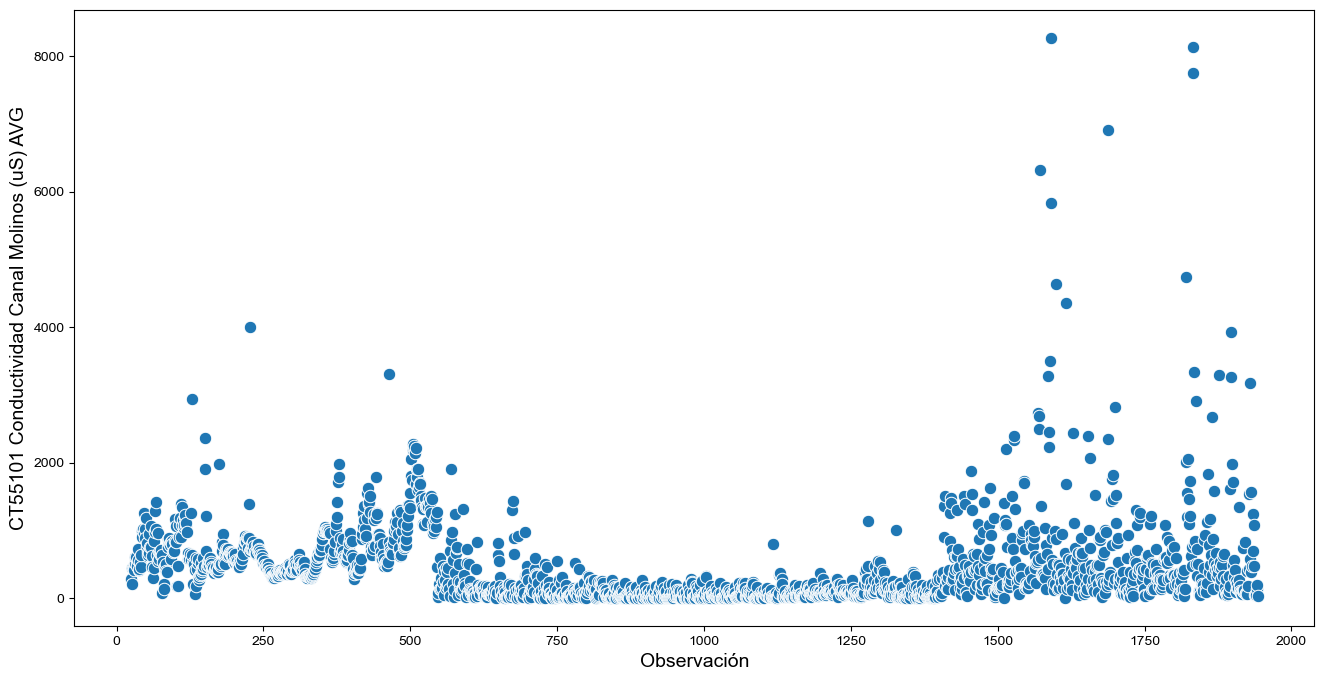

In [12]:
# Se grafica la variable objetivo
fig, ax = plt.subplots(figsize=(16,8)) # Se define tamaño de la figura y el los ejes
sns.set(style="darkgrid") # Se define el estilo del fondo
sns.set_context("talk") # Se define el estilo del contexto
ax = sns.scatterplot(x=df_raw.index, y=canal, data=df_raw) # Se configuran los parametros del grafico de dispersion
ax.set_ylabel(canal, fontsize=14) # Se define el titulo del eje y
ax.set_xlabel('Observación', fontsize=14) # Se define el titulo del eje X
plt.show() # Despliegue de grafica 

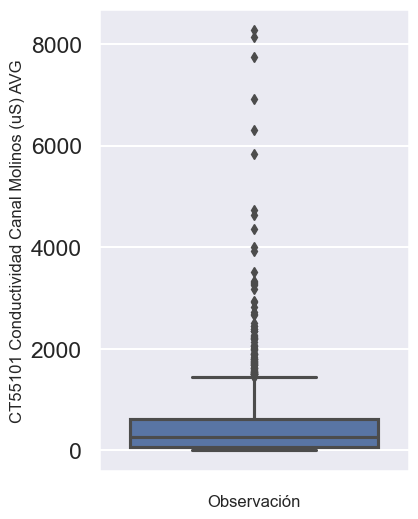

In [13]:
# Se grafican los valores atipicos de la variable objetivo
fig, ax = plt.subplots(figsize=(4,6)) # Se define tamaño de la figura y el los ejes
sns.set(style="darkgrid") # Se define el estilo del fondo
sns.set_context("talk") # Se define el estilo del contexto
ax = sns.boxplot(data=df_raw, y=canal) # Se configuran los parametros del grafico de cajas y bigotes
ax.set_ylabel(canal, fontsize=12) # Se define el titulo del eje y
ax.set_xlabel('Observación', fontsize=12) # Se define el titulo del eje X
plt.show() # Despliegue de grafica 

In [14]:
# Revision y cuantificacion de valores atipicos del conjunto de datos
quartiles= df_raw[canal].quantile([0.25,0.5,0.75]).values  # Se generan los 3 cuartiles de referencia 25%, 50% y 75%
q1 = quartiles[0] # Se asigna el 25% al cuartil 1
q2 = quartiles[1] # Se asigna el 50% al cuartil 2
q3 = quartiles[2] # Se asigna el 75% al cuartil 3
rango_inter = q3 - q1 # Se calcula el rango intercuartilico 75% - 25% 
limite_sup = q3 + 1.5*rango_inter # Se calcula el limite superior para valores atipicos
limite_inf = q1 - 1.5*rango_inter # Se calcula el limite inferior para valores atipicos
print(f" Limite superior: {limite_sup}, Limite inferior: {limite_inf}")

 Limite superior: 1443.1949999999997, Limite inferior: -746.1649999999998


### Analisis del conjunto de datos Original

**Se evaluan las metricas sin Dia de Zafra.**

Se realiza el analisis, utilizando el conjunto de datos completo.

In [15]:
# Imputación de Medias por Día para Valores faltantes o con Error
df_imp = df_raw.copy() # Se hace una copia del conjunto de datos
df_imp = funciones.imputacion_media_dia(df_imp, True)  # Se llama a la funcion de imputación de valores, y se configura para que no tome en cuenta el dia de zafra


# Creación de Nuevas Features 
# Evaluar la creación de nuevas variables

df_imp

,FT553705 Flujo agua asepsia Patio T-A (Gpm) AVG,FT553705 Flujo agua asepsia Patio T-A (Gpm) STD,FT553707 Flujo agua asepsia Molinos T-A (Gpm) AVG,FT553707 Flujo agua asepsia Molinos T-A (Gpm) STD,FT553706 Flujo agua asepsia Molinos T-B (Gpm) AVG,FT553706 Flujo agua asepsia Molinos T-B (Gpm) STD,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) AVG,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) STD,LT55M101 Nivel Chute Molino No. 1 TA (%) AVG,LT55M101 Nivel Chute Molino No. 1 TA (%) STD,...,LT585004 Nivel Vaso D5 (%) STD,LT580704 Nivel Vaso E1 (%) AVG,LT580704 Nivel Vaso E1 (%) STD,LT580604 Nivel Vaso E2 (%) AVG,LT580604 Nivel Vaso E2 (%) STD,LT581704 Nivel Vaso E3 (%) AVG,LT581704 Nivel Vaso E3 (%) STD,LT581603 Nivel Vaso E4 (%) AVG,LT581603 Nivel Vaso E4 (%) STD,CT55101 Conductividad Canal Molinos (uS) AVG
24,0.0,0.0,0.00,0.00,6.00,21.23,0.03,0.10,10.01,17.35,...,0.19,69.86,9.29,23.26,26.47,34.66,3.25,36.43,9.24,268.72
25,0.0,0.0,0.00,0.00,7.29,23.23,0.03,0.10,6.91,16.48,...,0.20,48.44,24.56,45.19,26.20,34.56,2.59,34.02,8.50,280.55
26,0.0,0.0,0.00,0.00,5.64,19.42,0.03,0.09,0.06,0.04,...,0.19,35.76,26.92,3.46,10.78,29.95,9.60,35.54,12.13,213.96
27,0.0,0.0,0.00,0.00,9.06,20.97,0.03,0.10,0.19,0.04,...,0.19,42.23,24.53,0.00,0.00,34.26,3.08,33.58,7.37,438.23
28,0.0,0.0,0.00,0.00,7.17,22.94,0.03,0.10,0.31,0.04,...,0.20,18.19,18.51,6.95,17.08,6.17,10.31,10.80,11.95,447.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,0.0,0.0,201.18,23.14,0.00,0.00,0.00,0.00,50.47,20.94,...,7.25,25.85,13.05,40.88,36.32,43.16,8.89,40.66,11.90,38.43
1940,0.0,0.0,42.73,67.39,0.00,0.00,0.00,0.01,51.03,12.44,...,21.79,42.68,14.39,24.64,26.68,53.41,13.44,44.09,9.66,43.29
1941,0.0,0.0,26.92,60.12,0.00,0.00,0.00,0.00,56.67,16.41,...,1.10,29.17,11.08,21.38,25.22,40.10,3.84,38.38,8.73,136.50
1942,0.0,0.0,39.39,64.29,0.00,0.00,0.00,0.00,57.53,17.72,...,0.90,20.74,8.37,0.05,0.03,39.91,2.05,40.46,8.59,191.89


In [16]:
df_imp.describe() # Estadisticas Descriptivas del conjunto de datos

,FT553705 Flujo agua asepsia Patio T-A (Gpm) AVG,FT553705 Flujo agua asepsia Patio T-A (Gpm) STD,FT553707 Flujo agua asepsia Molinos T-A (Gpm) AVG,FT553707 Flujo agua asepsia Molinos T-A (Gpm) STD,FT553706 Flujo agua asepsia Molinos T-B (Gpm) AVG,FT553706 Flujo agua asepsia Molinos T-B (Gpm) STD,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) AVG,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) STD,LT55M101 Nivel Chute Molino No. 1 TA (%) AVG,LT55M101 Nivel Chute Molino No. 1 TA (%) STD,...,LT585004 Nivel Vaso D5 (%) STD,LT580704 Nivel Vaso E1 (%) AVG,LT580704 Nivel Vaso E1 (%) STD,LT580604 Nivel Vaso E2 (%) AVG,LT580604 Nivel Vaso E2 (%) STD,LT581704 Nivel Vaso E3 (%) AVG,LT581704 Nivel Vaso E3 (%) STD,LT581603 Nivel Vaso E4 (%) AVG,LT581603 Nivel Vaso E4 (%) STD,CT55101 Conductividad Canal Molinos (uS) AVG
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.00000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,4.566609,0.768208,20.287094,44.430625,8.68151,18.230073,4.501245,10.151729,14.921948,12.916641,...,14.826224,35.086255,14.315349,37.700854,10.651469,34.824260,12.203016,39.852823,10.273948,460.226802
std,11.579331,1.985348,16.232338,21.994578,11.15926,19.988396,14.130790,25.990155,14.373135,8.864586,...,9.215309,17.967346,8.487802,19.629149,8.051861,17.233209,8.091933,17.076569,8.313882,655.500123
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.150000
25%,0.000000,0.000000,10.702500,38.810000,0.00000,0.000000,0.000000,0.010000,2.507500,4.780000,...,8.182500,24.395000,9.475000,27.832500,4.657500,26.647500,6.065000,35.522500,4.740000,74.845000
50%,0.000000,0.000000,18.475000,50.635000,4.69500,7.335000,0.000000,0.030000,10.655000,13.745000,...,14.985000,34.850000,14.310000,41.020000,10.245000,35.775000,11.985000,44.510000,8.340000,269.845000
75%,0.000000,0.000000,27.385000,58.910000,15.66250,41.142500,0.010000,0.060000,24.177500,19.580000,...,20.612500,45.752500,18.972500,49.927500,15.127500,44.710000,17.362500,48.002500,13.927500,622.185000
max,52.930000,18.710000,201.180000,120.840000,150.58000,88.300000,168.550000,146.060000,86.400000,45.160000,...,48.600000,100.000000,47.930000,100.000000,45.760000,100.000000,49.250000,100.000000,46.460000,8273.000000


### Tratamiento de Outliers y Distribución de Frecuencias de Valores de Conductividad

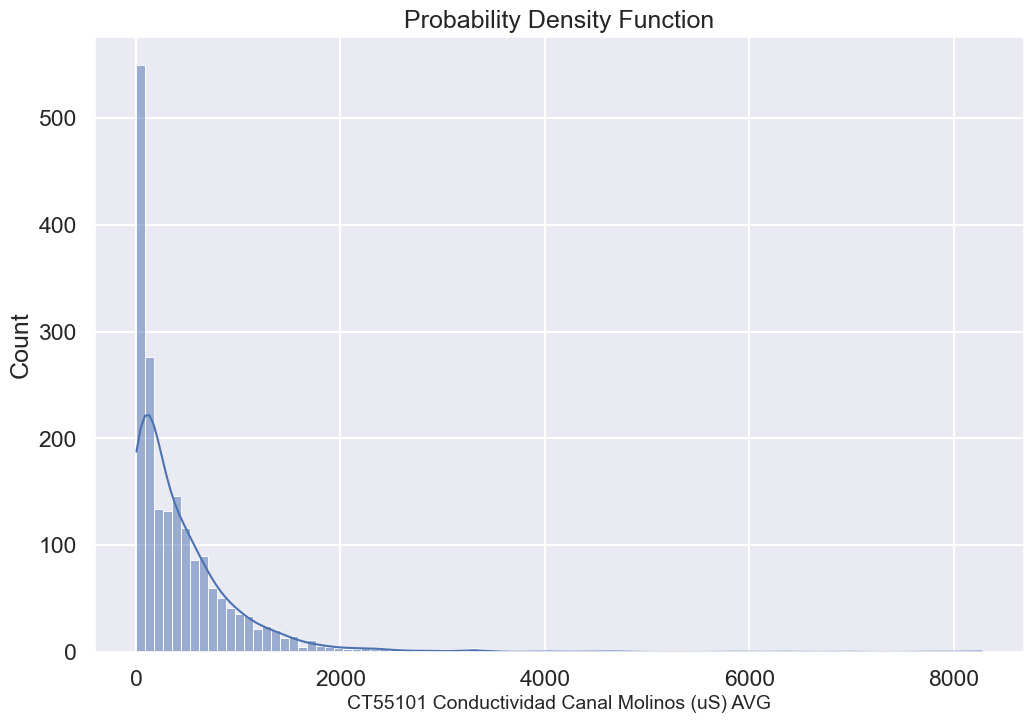

 Estadísticas de Conductividad: 


count    1920.000000
mean      460.226802
std       655.500123
min         5.150000
25%        74.845000
50%       269.845000
75%       622.185000
max      8273.000000
Name: CT55101 Conductividad Canal Molinos (uS) AVG, dtype: float64

In [17]:
df = funciones.outliers(df_imp,canal,0) # Se grafica el histograma y se eliminan valores atipicos en caso necesario

### Determinación de Umbral Óptimo

Se aplica una **binarización** a la variable de conductividad. La binarización consiste en *transformar* la variable continua de conductividad a una variable binaria de *presencia* o *no presencia* de conductividad. Esto porque no toda conductividad se debe necesariamente a trazas de azúcar, y en la práctica es más útil definir un límite superior para esta variable. 

La binarización se implementa de forma que: Una **alta conductividad es una clase POSITIVA** y una **baja conductividad es una clase NEGATIVA**.

Adicionalmente, debido a la distribución *sesgada* de la variable de conductividad, es posible que una mala selección del umbral produzca un imbalance en el conjunto de entrenamiento y por lo tanto, métricas de detección del algoritmo que no son óptimas.

#### K-Means Clustering
Para poder distinguir entre clases, se ejecuta un algoritmo de clustering no-supervisado, con el propósito de encontrar **"regiones de operación"** en los datos, y luego verificar si estas regiones tienen en común algún rango de valores de conductividad.

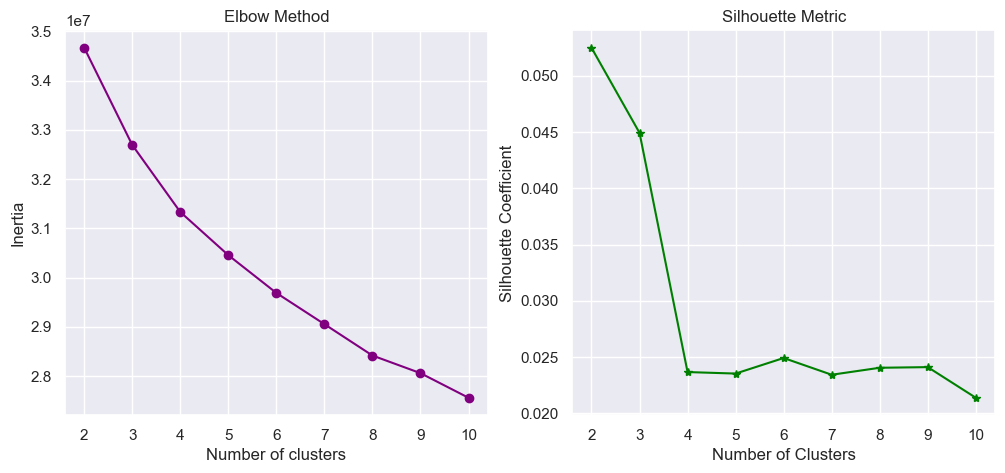

In [18]:
funciones.exploracion_clusters(df,canal) # Se revisan las metricas para poder realizar agrupaciones en el conjunto de datos 

Puede observarse que **las métricas de cohesión son más altas para 4 agrupaciones**. Se forman los 3 grupos utilizando el algoritmo K-Means, con n=4. Luego, se grafica la serie de tiempo de la conductividad durante la zafra y se colorean las regiones encontradas.

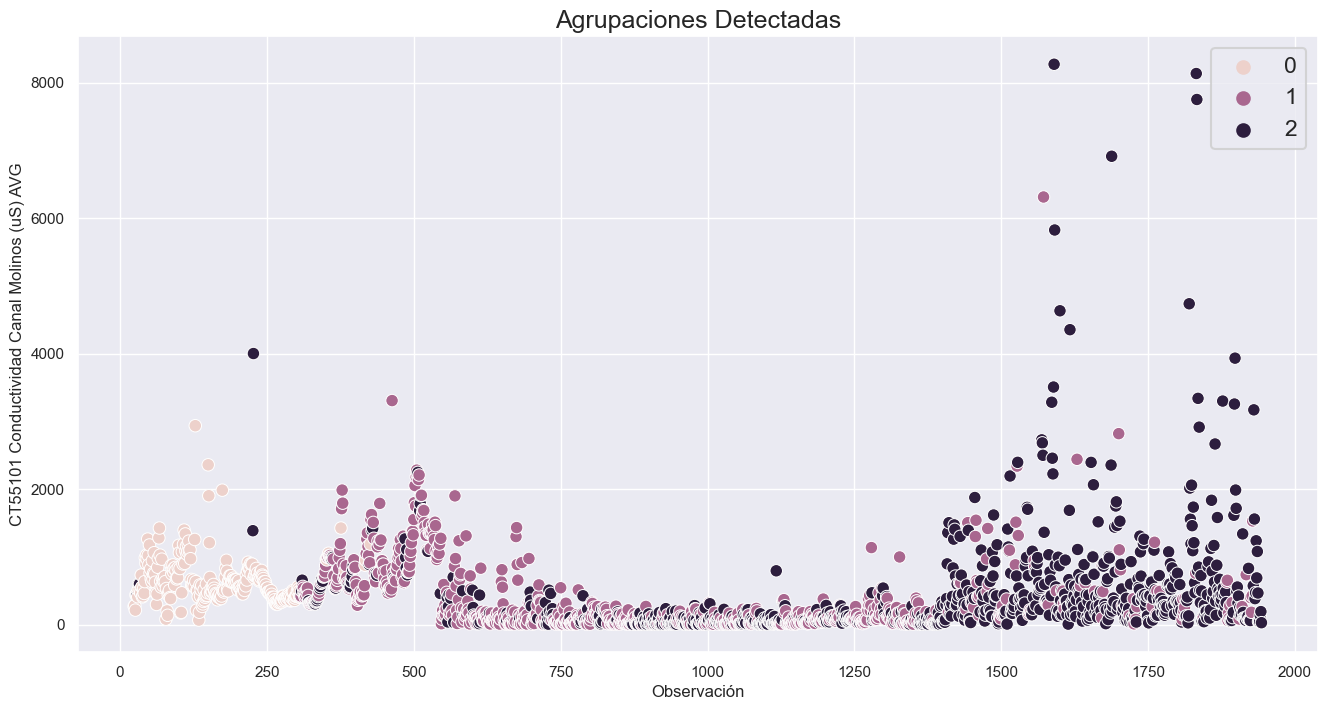

 Medias por Agrupación: 


,FT553705 Flujo agua asepsia Patio T-A (Gpm) AVG,FT553705 Flujo agua asepsia Patio T-A (Gpm) STD,FT553707 Flujo agua asepsia Molinos T-A (Gpm) AVG,FT553707 Flujo agua asepsia Molinos T-A (Gpm) STD,FT553706 Flujo agua asepsia Molinos T-B (Gpm) AVG,FT553706 Flujo agua asepsia Molinos T-B (Gpm) STD,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) AVG,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) STD,LT55M101 Nivel Chute Molino No. 1 TA (%) AVG,LT55M101 Nivel Chute Molino No. 1 TA (%) STD,LT55M201 Nivel Chute Molino No. 2 TA (%) AVG,LT55M201 Nivel Chute Molino No. 2 TA (%) STD,LT55M301 Nivel Chute Molino No. 3 TA (%) AVG,LT55M301 Nivel Chute Molino No. 3 TA (%) STD,LT55M401 Nivel Chute Molino No. 4 TA (%) AVG,LT55M401 Nivel Chute Molino No. 4 TA (%) STD,LT55M501 Nivel Chute Molino No. 5 TA (%) AVG,LT55M501 Nivel Chute Molino No. 5 TA (%) STD,LT55M601 Nivel Chute Molino No. 6 TA (%) AVG,LT55M601 Nivel Chute Molino No. 6 TA (%) STD,LT55N101 Nivel Chute Molino No. 1 TB (%) AVG,LT55N101 Nivel Chute Molino No. 1 TB (%) STD,LT55N201 Nivel Chute Molino No. 2 TB (%) AVG,LT55N201 Nivel Chute Molino No. 2 TB (%) STD,LT55N301 Nivel Chute Molino No. 3 TB (%) AVG,LT55N301 Nivel Chute Molino No. 3 TB (%) STD,LT55N401 Nivel Chute Molino No. 4 TB (%) AVG,LT55N401 Nivel Chute Molino No. 4 TB (%) STD,LT55N501 Nivel Chute Molino No. 5 TB (%) AVG,LT55N501 Nivel Chute Molino No. 5 TB (%) STD,LT55N601 Nivel Chute Molino No. 6 TB (%) AVG,LT55N601 Nivel Chute Molino No. 6 TB (%) STD,LT555803 Nivel Tanque Jugo Mezclado TB ( %) AVG,LT555803 Nivel Tanque Jugo Mezclado TB ( %) STD,LT555801 Nivel Tanque Jugo Filtrado TA ( %) AVG,LT555801 Nivel Tanque Jugo Filtrado TA ( %) STD,LT555804 Nivel Tanque Jugo Mezclado TB ( %) AVG,LT555804 Nivel Tanque Jugo Mezclado TB ( %) STD,LT555802 Nivel Tanque Jugo Filtrado TB ( %) AVG,LT555802 Nivel Tanque Jugo Filtrado TB ( %) STD,LT58A101 Nivel Vaso A1 (%) AVG,LT58A101 Nivel Vaso A1 (%) STD,LT58A201 Nivel Vaso A2 (%) AVG,LT58A201 Nivel Vaso A2 (%) STD,LT58A301 Nivel Vaso A3 (%) AVG,LT58A301 Nivel Vaso A3 (%) STD,LT58A404 Nivel Vaso A4 (%) AVG,LT58A404 Nivel Vaso A4 (%) STD,LT584001 Nivel Vaso A5 (%) AVG,LT584001 Nivel Vaso A5 (%) STD,LT584104 Nivel Vaso A6 (%) AVG,LT584104 Nivel Vaso A6 (%) STD,LT584204 Nivel Vaso A7 (%) AVG,LT584204 Nivel Vaso A7 (%) STD,LT584301 Nivel Vaso A8 (%) AVG,LT584301 Nivel Vaso A8 (%) STD,LT584401 Nivel Vaso A9 (%) AVG,LT584401 Nivel Vaso A9 (%) STD,LT58P604 Nivel Vaso B1 (%) AVG,LT58P604 Nivel Vaso B1 (%) STD,LT585604 Nivel Vaso B2 (%) AVG,LT585604 Nivel Vaso B2 (%) STD,LT585501 Nivel Vaso B3 (%) AVG,LT585501 Nivel Vaso B3 (%) STD,LT585401 Nivel Vaso B4 (%) AVG,LT585401 Nivel Vaso B4 (%) STD,LT585304 Nivel Vaso B5 (%) AVG,LT585304 Nivel Vaso B5 (%) STD,LT585204 Nivel Vaso B6 (%) AVG,LT585204 Nivel Vaso B6 (%) STD,LT58P704 Nivel Vaso B7 (%) AVG,LT58P704 Nivel Vaso B7 (%) STD,LT58D804 Nivel Vaso B8 (%) AVG,LT58D804 Nivel Vaso B8 (%) STD,LT58D201 Nivel Vaso C1 (%) AVG,LT58D201 Nivel Vaso C1 (%) STD,LT585101 Nivel Vaso C2 (%) AVG,LT585101 Nivel Vaso C2 (%) STD,LT58D704 Nivel Vaso C3 (%) AVG,LT58D704 Nivel Vaso C3 (%) STD,LT58D603 Nivel Vaso C4 (%) AVG,LT58D603 Nivel Vaso C4 (%) STD,LT584903 Nivel Vaso C5 (%) AVG,LT584903 Nivel Vaso C5 (%) STD,LT584803 Nivel Vaso D1 (%) AVG,LT584803 Nivel Vaso D1 (%) STD,LT584503 Nivel Vaso D2 (%) AVG,LT584503 Nivel Vaso D2 (%) STD,LT584604 Nivel Vaso D3 (%) AVG,LT584604 Nivel Vaso D3 (%) STD,LT584704 Nivel Vaso D4 (%) AVG,LT584704 Nivel Vaso D4 (%) STD,LT585004 Nivel Vaso D5 (%) AVG,LT585004 Nivel Vaso D5 (%) STD,LT580704 Nivel Vaso E1 (%) AVG,LT580704 Nivel Vaso E1 (%) STD,LT580604 Nivel Vaso E2 (%) AVG,LT580604 Nivel Vaso E2 (%) STD,LT581704 Nivel Vaso E3 (%) AVG,LT581704 Nivel Vaso E3 (%) STD,LT581603 Nivel Vaso E4 (%) AVG,LT581603 Nivel Vaso E4 (%) STD,CT55101 Conductividad Canal Molinos (uS) AVG
group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,29.625714,4.992857,3.509728,12.801156,5.318129,7.443299

 Desviaciones Estándar por Agrupación: 


,FT553705 Flujo agua asepsia Patio T-A (Gpm) AVG,FT553705 Flujo agua asepsia Patio T-A (Gpm) STD,FT553707 Flujo agua asepsia Molinos T-A (Gpm) AVG,FT553707 Flujo agua asepsia Molinos T-A (Gpm) STD,FT553706 Flujo agua asepsia Molinos T-B (Gpm) AVG,FT553706 Flujo agua asepsia Molinos T-B (Gpm) STD,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) AVG,FT553704 Flujo Agua de Asepsia a Patio T-B (Gpm) STD,LT55M101 Nivel Chute Molino No. 1 TA (%) AVG,LT55M101 Nivel Chute Molino No. 1 TA (%) STD,LT55M201 Nivel Chute Molino No. 2 TA (%) AVG,LT55M201 Nivel Chute Molino No. 2 TA (%) STD,LT55M301 Nivel Chute Molino No. 3 TA (%) AVG,LT55M301 Nivel Chute Molino No. 3 TA (%) STD,LT55M401 Nivel Chute Molino No. 4 TA (%) AVG,LT55M401 Nivel Chute Molino No. 4 TA (%) STD,LT55M501 Nivel Chute Molino No. 5 TA (%) AVG,LT55M501 Nivel Chute Molino No. 5 TA (%) STD,LT55M601 Nivel Chute Molino No. 6 TA (%) AVG,LT55M601 Nivel Chute Molino No. 6 TA (%) STD,LT55N101 Nivel Chute Molino No. 1 TB (%) AVG,LT55N101 Nivel Chute Molino No. 1 TB (%) STD,LT55N201 Nivel Chute Molino No. 2 TB (%) AVG,LT55N201 Nivel Chute Molino No. 2 TB (%) STD,LT55N301 Nivel Chute Molino No. 3 TB (%) AVG,LT55N301 Nivel Chute Molino No. 3 TB (%) STD,LT55N401 Nivel Chute Molino No. 4 TB (%) AVG,LT55N401 Nivel Chute Molino No. 4 TB (%) STD,LT55N501 Nivel Chute Molino No. 5 TB (%) AVG,LT55N501 Nivel Chute Molino No. 5 TB (%) STD,LT55N601 Nivel Chute Molino No. 6 TB (%) AVG,LT55N601 Nivel Chute Molino No. 6 TB (%) STD,LT555803 Nivel Tanque Jugo Mezclado TB ( %) AVG,LT555803 Nivel Tanque Jugo Mezclado TB ( %) STD,LT555801 Nivel Tanque Jugo Filtrado TA ( %) AVG,LT555801 Nivel Tanque Jugo Filtrado TA ( %) STD,LT555804 Nivel Tanque Jugo Mezclado TB ( %) AVG,LT555804 Nivel Tanque Jugo Mezclado TB ( %) STD,LT555802 Nivel Tanque Jugo Filtrado TB ( %) AVG,LT555802 Nivel Tanque Jugo Filtrado TB ( %) STD,LT58A101 Nivel Vaso A1 (%) AVG,LT58A101 Nivel Vaso A1 (%) STD,LT58A201 Nivel Vaso A2 (%) AVG,LT58A201 Nivel Vaso A2 (%) STD,LT58A301 Nivel Vaso A3 (%) AVG,LT58A301 Nivel Vaso A3 (%) STD,LT58A404 Nivel Vaso A4 (%) AVG,LT58A404 Nivel Vaso A4 (%) STD,LT584001 Nivel Vaso A5 (%) AVG,LT584001 Nivel Vaso A5 (%) STD,LT584104 Nivel Vaso A6 (%) AVG,LT584104 Nivel Vaso A6 (%) STD,LT584204 Nivel Vaso A7 (%) AVG,LT584204 Nivel Vaso A7 (%) STD,LT584301 Nivel Vaso A8 (%) AVG,LT584301 Nivel Vaso A8 (%) STD,LT584401 Nivel Vaso A9 (%) AVG,LT584401 Nivel Vaso A9 (%) STD,LT58P604 Nivel Vaso B1 (%) AVG,LT58P604 Nivel Vaso B1 (%) STD,LT585604 Nivel Vaso B2 (%) AVG,LT585604 Nivel Vaso B2 (%) STD,LT585501 Nivel Vaso B3 (%) AVG,LT585501 Nivel Vaso B3 (%) STD,LT585401 Nivel Vaso B4 (%) AVG,LT585401 Nivel Vaso B4 (%) STD,LT585304 Nivel Vaso B5 (%) AVG,LT585304 Nivel Vaso B5 (%) STD,LT585204 Nivel Vaso B6 (%) AVG,LT585204 Nivel Vaso B6 (%) STD,LT58P704 Nivel Vaso B7 (%) AVG,LT58P704 Nivel Vaso B7 (%) STD,LT58D804 Nivel Vaso B8 (%) AVG,LT58D804 Nivel Vaso B8 (%) STD,LT58D201 Nivel Vaso C1 (%) AVG,LT58D201 Nivel Vaso C1 (%) STD,LT585101 Nivel Vaso C2 (%) AVG,LT585101 Nivel Vaso C2 (%) STD,LT58D704 Nivel Vaso C3 (%) AVG,LT58D704 Nivel Vaso C3 (%) STD,LT58D603 Nivel Vaso C4 (%) AVG,LT58D603 Nivel Vaso C4 (%) STD,LT584903 Nivel Vaso C5 (%) AVG,LT584903 Nivel Vaso C5 (%) STD,LT584803 Nivel Vaso D1 (%) AVG,LT584803 Nivel Vaso D1 (%) STD,LT584503 Nivel Vaso D2 (%) AVG,LT584503 Nivel Vaso D2 (%) STD,LT584604 Nivel Vaso D3 (%) AVG,LT584604 Nivel Vaso D3 (%) STD,LT584704 Nivel Vaso D4 (%) AVG,LT584704 Nivel Vaso D4 (%) STD,LT585004 Nivel Vaso D5 (%) AVG,LT585004 Nivel Vaso D5 (%) STD,LT580704 Nivel Vaso E1 (%) AVG,LT580704 Nivel Vaso E1 (%) STD,LT580604 Nivel Vaso E2 (%) AVG,LT580604 Nivel Vaso E2 (%) STD,LT581704 Nivel Vaso E3 (%) AVG,LT581704 Nivel Vaso E3 (%) STD,LT581603 Nivel Vaso E4 (%) AVG,LT581603 Nivel Vaso E4 (%) STD,CT55101 Conductividad Canal Molinos (uS) AVG
group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,11.331792,2.140922,5.297557,18.045458,4.565966,4.321705

In [19]:
funciones.clustering(df,canal,3) # Se configura para generar la cantidad de grupos deseada en el conjunto de datos

Puede observarse que las agrupaciones 1 y 2 comparten tendencias de conductividad por debajo de los 500 uS, mientras que la agrupación 0, que corresponden a datos al arranque de zafra, tiene una media cerca de los 650 uS.  

Para explorar este umbral de conductividad, se implementa un algoritmo que explora *distintos umbrales de conductividad* y grafica las métricas de entrenamiento para cada selección:

- **Precision:** Habilidad del Clasificador de minimizar Falsos Positivos.
- **Accuracy:** Habilidad del Clasificador de Detectar Verdaderos Positivos y Verdaderos Negativos.
- **Recall:** Habilidad del Clasificador de Detectar Verdaderos Positivos.
- **F1:** Media Ponderada de la Precision y el Recall.
- **Overall:** Media Aritmética de todas las métricas anteriores.


De esta forma, se obtiene una **propuesta de umbral óptima**.

,Precision,Accuracy,F1,Recall,AUC (%),Overall,Clase Positiva (%)
Umbral Conductividad,,,,,,,
50.0,0.744886,0.782986,0.871795,0.923913,0.754985,0.815713,81.510417
100.0,0.755872,0.758681,0.830694,0.837838,0.803396,0.797296,70.104167
150.0,0.749905,0.748264,0.793741,0.785915,0.832860,0.782137,61.718750
200.0,0.774439,0.774306,0.789644,0.787097,0.866299,0.798357,55.208333
250.0,0.784757,0.784722,0.786942,0.784247,0.871334,0.802400,51.458333
300.0,0.790115,0.789931,0.775510,0.779851,0.870239,0.801129,47.604167
350.0,0.793122,0.793403,0.757637,0.753036,0.863148,0.792069,43.906250
400.0,0.763620,0.765625,0.692483,0.669604,0.838052,0.745877,40.000000
500.0,0.753512,0.763889,0.566879,0.494444,0.832337,0.682212,31.614583


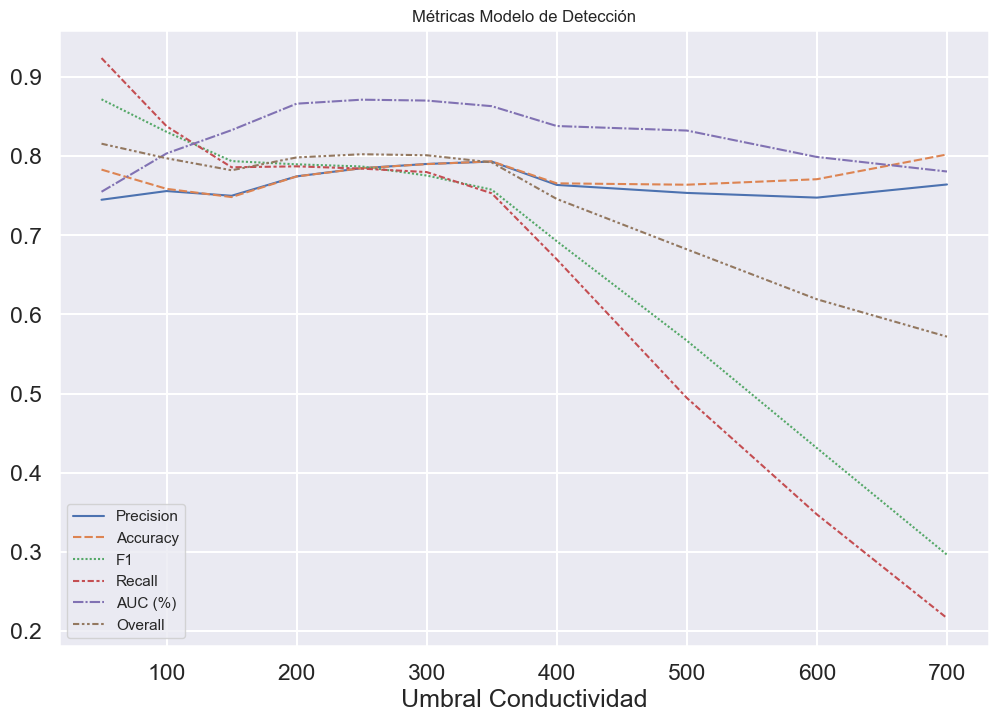

In [20]:
funciones.busqueda_umbral(df,canal,[50,100,150,200,250,300,350,400,500,600,700]) # Se revisan las metricas para diferentes valores de umbral

#### Selección de Umbral
El criterio para seleccionar el umbral se propone sea el del **"cima"**. En este método se selecciona un umbral a partir del cual las métricas caen por debajo de un nivel "aceptable".

Por ejemplo, una conductividad de 250 nos proporciona suficiente rango y además las métricas están arriba del 80%.


### Entrenamiento Modelo de Clasificación
Basado en los resultados anteriores, se selecciona un umbral y se entrena el modelo de detección.

In [21]:
# Umbral de Detección
umbral_final = 250 # Se define el umbral de deteccion segun las metricas revisadas

# Binarización y construcción del Dataset de Entrenamiento y Validación
X = df.drop(canal, axis=1) # Se define el conjunto de datos de las variables independientes 
y = df[canal].apply(lambda x: 1 if x > umbral_final else 0) # Se define la variable dependiente 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123456) # Se genera el conjunto de datos de entrenamiento y prueba # Umbral de Detección

In [22]:
# Estandarización y Entrenamiento
scaler = StandardScaler()   # Se deine procedimiento de Escalado
X_train_scaled = scaler.fit_transform(X_train) # Se aplica el escalado al conjunto de datos de entrenamiento de las variables independientes   
X_test_scaled = scaler.transform(X_test) # Se aplica el escalado al conjunto de datos de prueba de las variables independientes
model = LogisticRegression() # Se define el algoritmo para el modelo
model.fit(X_train_scaled, y_train) # Se ajusta el modelo con el conjunto de datos de entrenamiento escalado de variables independientes y con la variable dependiente  
coefficients = model.coef_[0] # Se extraen los coeficientes del modelo

### Métricas Finales de Entrenamiento y Matriz de Confusión
Se muestran las métricas del modelo final y su desempeño para detectar Verdaderos Positivos, Verdaderos Negativos, Falsos Positivos y Falsos Negativos.

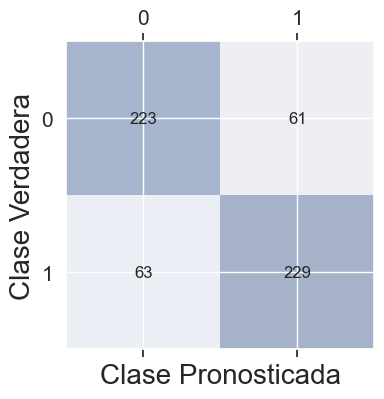

In [23]:
y_pred = model.predict(X_test_scaled) # Se evalua el modelo con el conjunto de datos de prueba escalado 
y_pred_prob = model.predict_proba(X_test_scaled) # Se evaluala la probabilidad de las predicciones realizadas por el modelo 

conf_mat = funciones.matriz_confusion(y_test,y_pred) # Se muestra la matriz de confusion

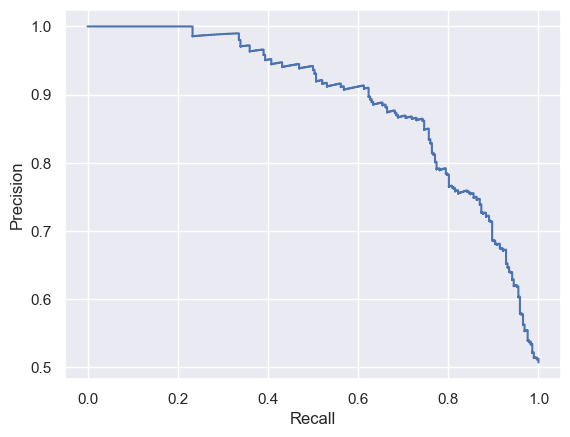

,Umbral Conductividad,Precision (%),Accuracy (%),F1 (%),Recall (%),AUC (%),Overall (%)
0,250.0,78.475672,78.472222,78.694158,78.424658,87.133417,80.240025


In [24]:
funciones.metricas_finales(y_test,y_pred,y_pred_prob[:, 1],umbral_final) # Se muestran las metricas finales del modelo generado con el umbral definido 

### Factores de Importancia
Para la determinación de los factores de importancia se presentan dos perspectivas: Importancia por Magnitud del Factor e Importancia por Control del Factor.

#### Importancia por Magnitud del Factor
Esta importancia es el peso relativo que tiene este factor respecto a los demás factores, para contribuir positivamente o negativamente a la conductividad.
Si la contribución es positiva, a mayor magnitud del factor, mayor probabilidad de detectar la clase positiva (mayor probabilidad de alta conductividad).
Si la contribución es negativa, a mayor magnitud del factor, mayor probabilidad de detectar la clase negativa (menor probabilidad de alta conductividad).

#### Importancia por Control del Factor
Esta importancia se calcula a partir del efecto que tiene aleatorizar la variable (manteniendo todas las demás constantes) sobre la conductividad. Esto es especialmente importante para identificar **el efecto que tiene la precisión del control de la variable sobre la conductividad final**.

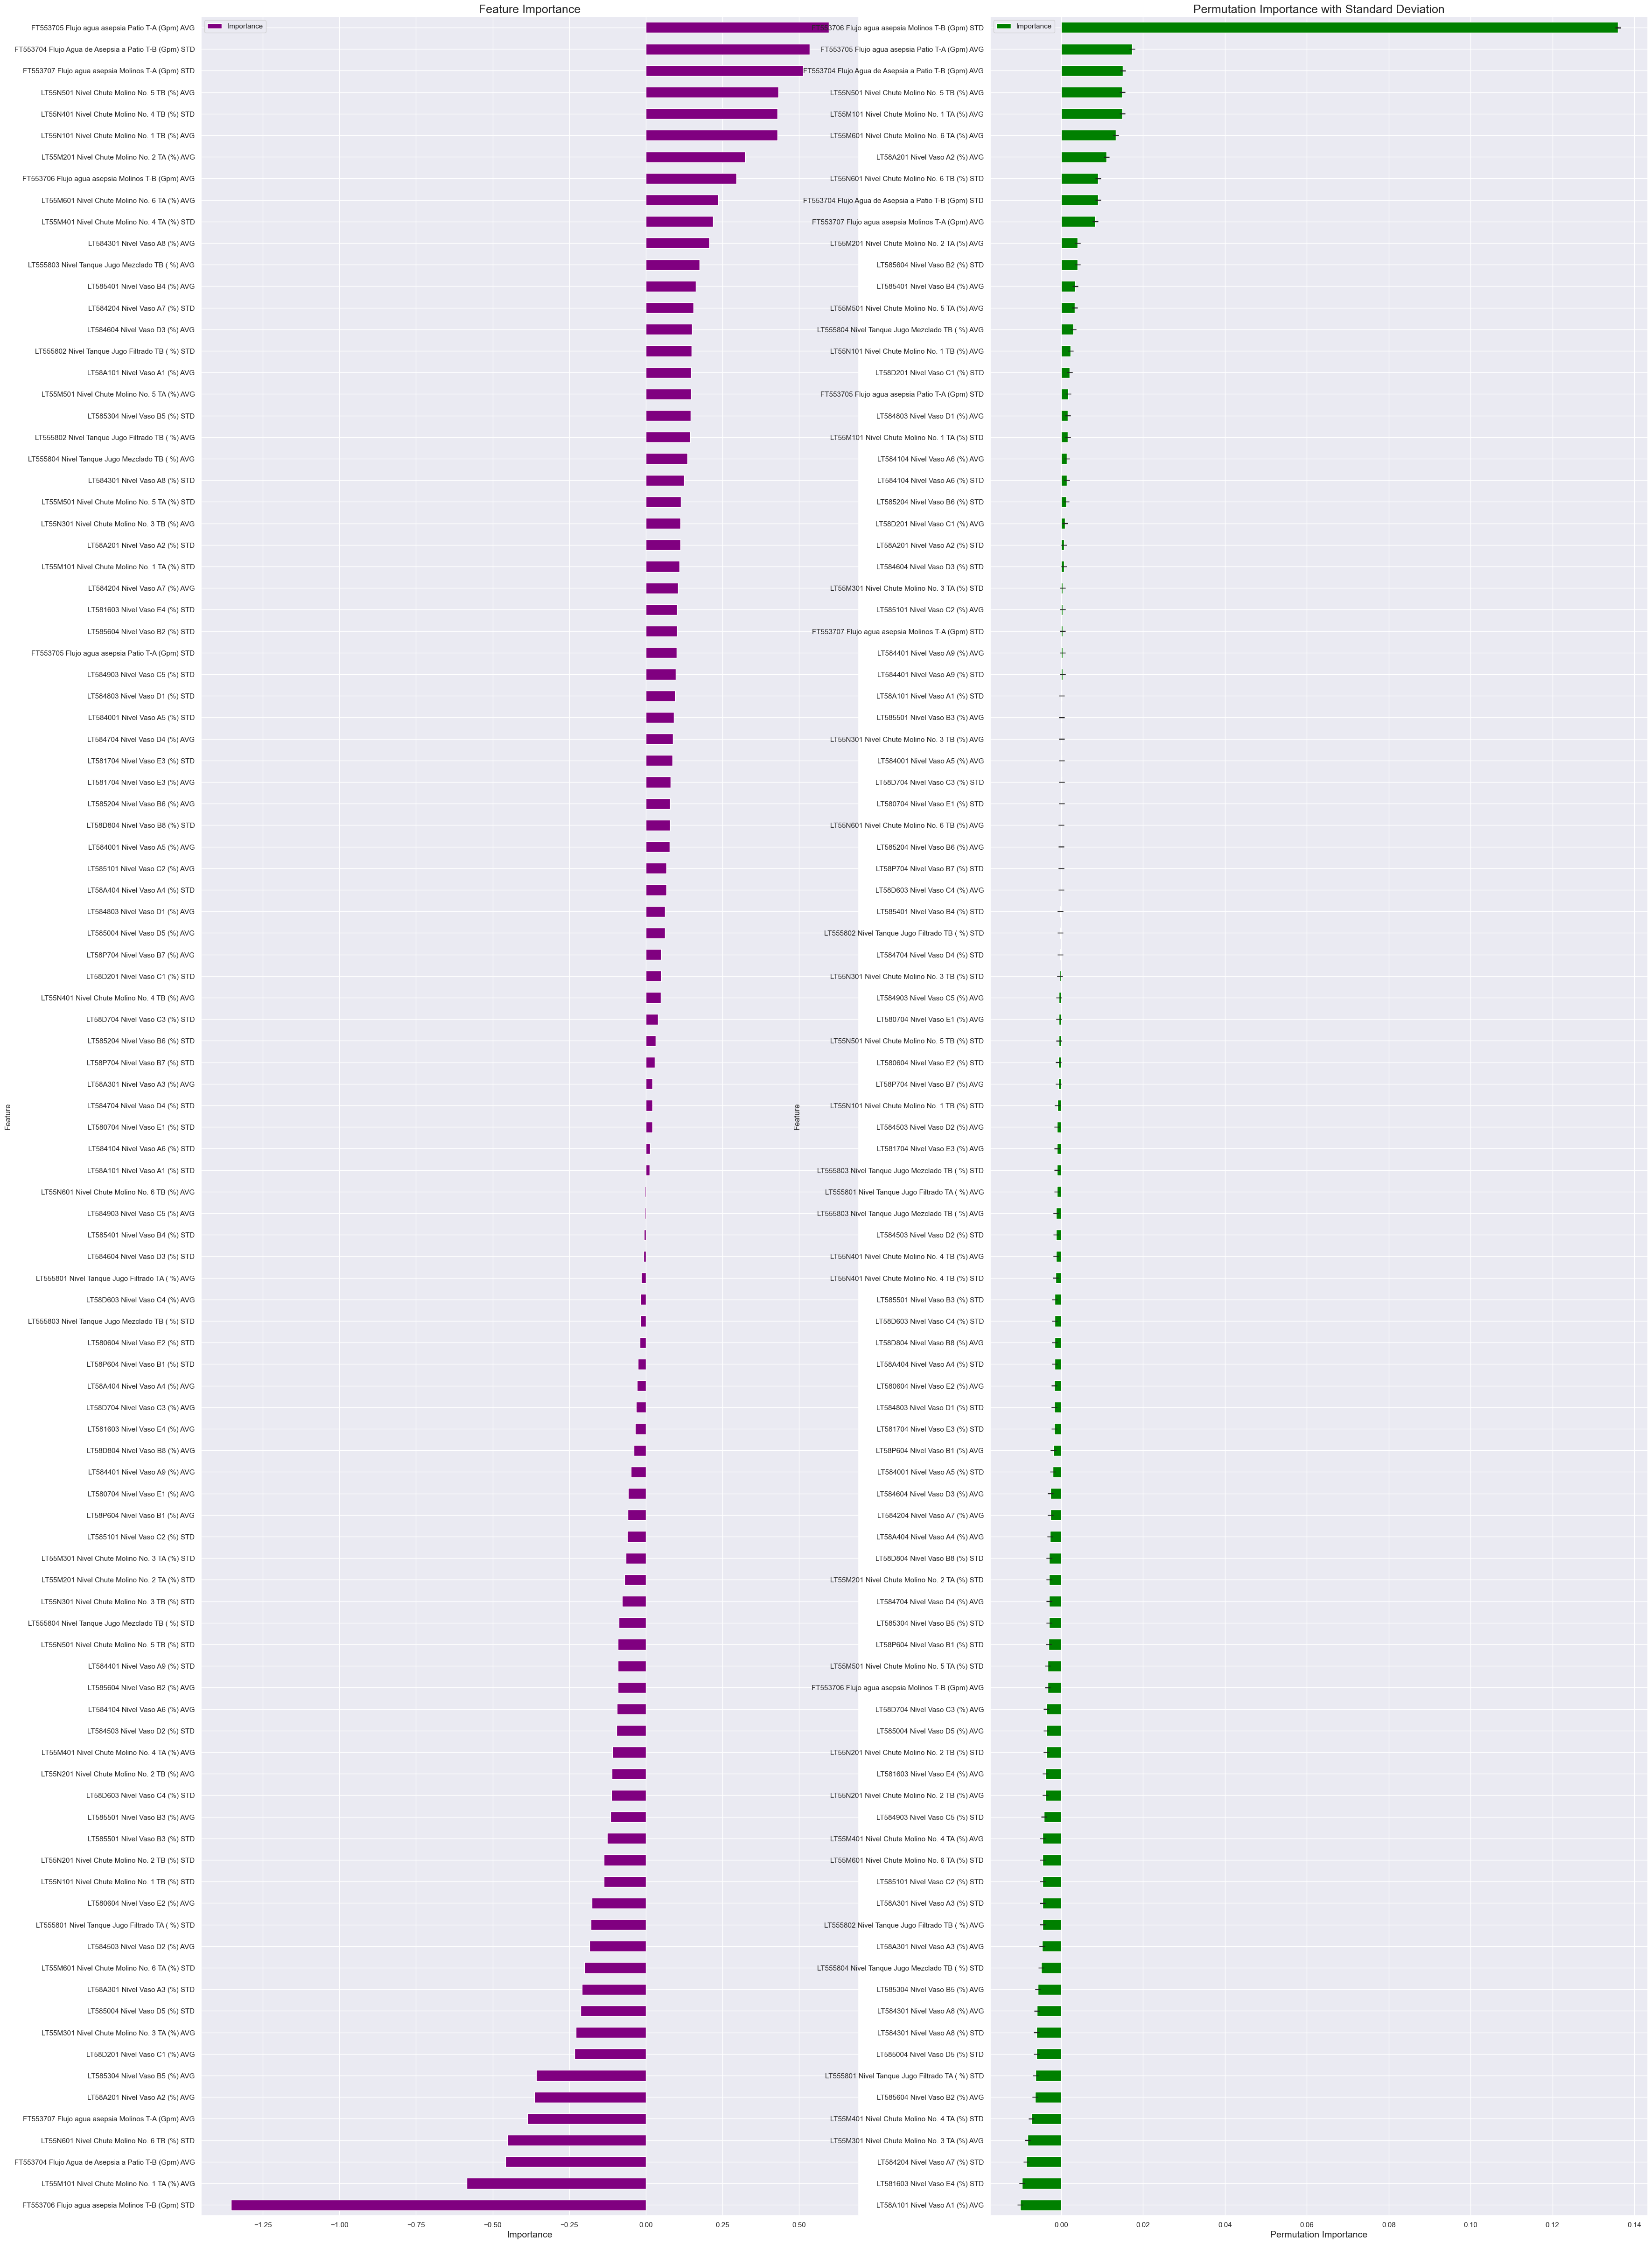

In [25]:
funciones.importancias_modelo(model,X,coefficients,X_test_scaled,y_test) # Se muestrasn los factores de importancia por Magnitud y Control 

### Probabilidad de Clase Positiva (Alta Conductividad)
El modelo permite conocer cómo cada factor impacta la probabilidad de obtener la **clase positiva** (*alta conductividad*). 

Para ello se presentan los **incrementos en probabilidad**: *Si el factor tiene un incremento unitario, cuánto aumenta la probabilidad de tener una alta conductividad*.

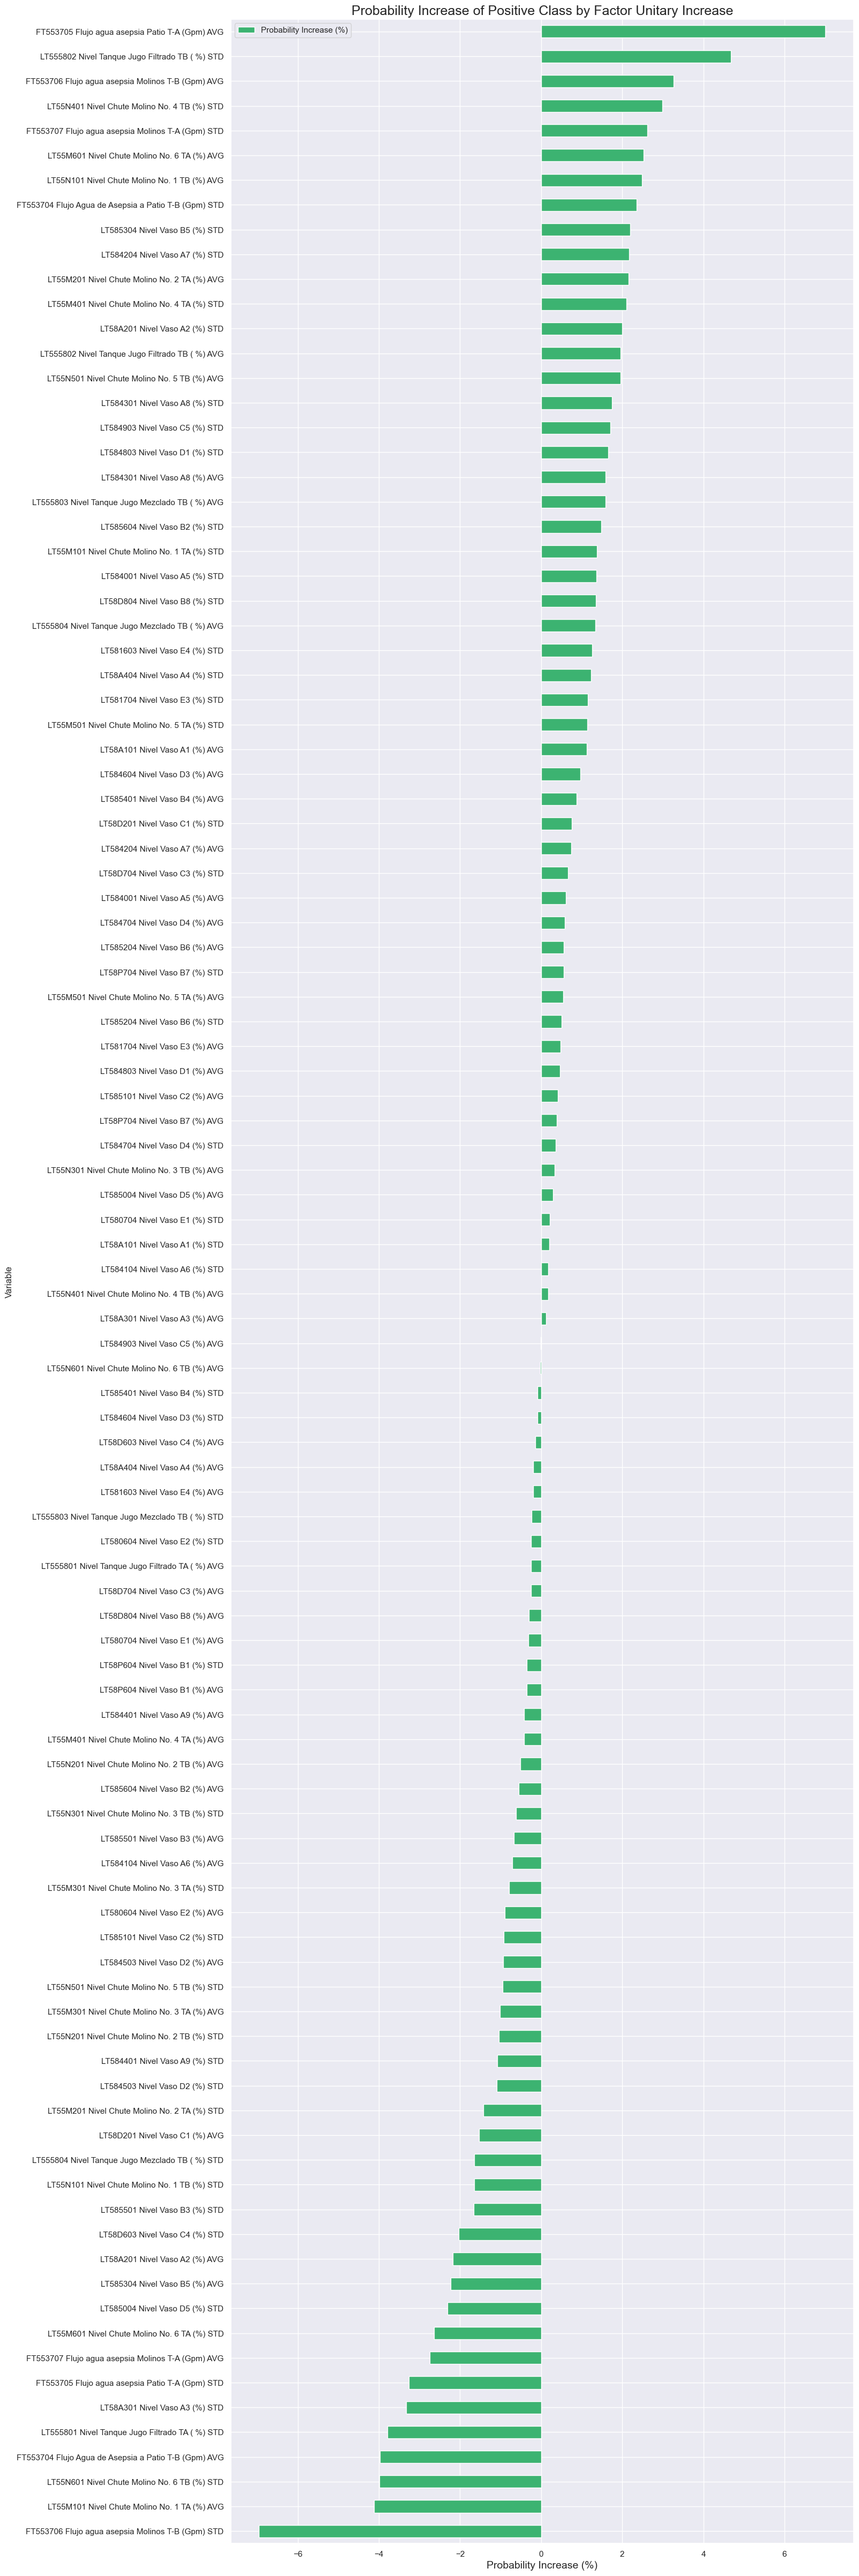

In [26]:
funciones.logprob(X,X_train,y_train) # Se muestran los factores de importancia para la Clase Positiva 

### Conclusiones:
Dados los factores de importancia identificados, las recomendaciones son las siguientes:
- Para los **factores con mayor importancia por magnitud** se recomienda controlar con un **SP menor** (si la importancia por magnitud es **positiva**) o con un **SP mayor** (si la importancia por magnitud es **negativa**) para *reducir la probabilidad de tener alta conductividad*.
- Para conocer *qué tanto incrementar o decrementar el SP del factor*, se verifica su contribución a la **Probabilidad de Clase Positiva**: Si la contribución es positiva, se recomienda reducir el SP. Si la contribución es negativa, se recomienda aumentar el SP. Ambas acciones **reducirán la probabilidad de ocurrencia de la clase positiva** (alta conductividad).
- Para los **factores con mayor importancia por control** se recomienda **reducir la varianza de la variable** (reducir su variación si es posible por medios manuales o ajustes de los lazos de control involucrados). En el caso de *importancias negativas*, significa que los algoritmos *no encontraron evidencia de que el control de esta variable importe para la estabilidad de la conductividad*.